In [1]:
from itertools import combinations
import numpy as np
import chiLife as xl
import MDAnalysis as mda 
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('chiLife')

C:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
r = np.linspace(0, 100, 256)
# omp = xl.fetch('1omp')
# anf = xl.fetch('1anf')

omp = mda.Universe('1omp.pdb')
anf = mda.Universe('1anf.pdb')

# Get residues that are solvent accessible in both conformations
omp_SASR = xl.get_sas_res(omp, 50)
anf_SASR = xl.get_sas_res(anf, 50)
SASR = omp_SASR & anf_SASR

#  Model spin labels on apo and holo
omp_spin_labels = {(site, chain): xl.SpinLabel('R1A', site, omp, chain=chain) for site, chain in tqdm(SASR)}
anf_spin_labels = {(site, chain): xl.SpinLabel('R1A', site, anf, chain=chain) for site, chain in tqdm(SASR)}


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:05<00:00, 19.43it/s]


In [50]:

# Simulate distance distributions for all possible combinations  
Apo_pairs = list(combinations(anf_spin_labels.values(), r=2))
Holo_pairs = list(combinations(anf_spin_labels.values(), r=2))
Ps_omp = np.array([xl.distance_distribution(SL1, SL2, r) for SL1, SL2 in Apo_pairs])
Ps_anf = np.array([xl.distance_distribution(SL1, SL2, r) for SL1, SL2 in Holo_pairs])

EMDs = [wasserstein_distance(r, r, P_omp, P_anf) for P_omp, P_anf in zip(Ps_omp, Ps_anf)]

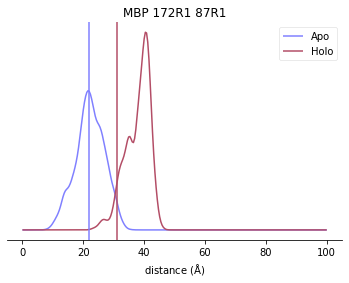

In [51]:
args = np.argsort(EMDs)[::-1]
arg = args[2]
site1, site2 = all_pairs[arg]
omp_SL1 = omp_spin_labels[site1]
omp_SL2 = omp_spin_labels[site2]

anf_SL1 = anf_spin_labels[site1]
anf_SL2 = anf_spin_labels[site2]

omp_cbd = np.linalg.norm(omp_SL1.coords[0, omp_SL1.atom_names=='CB'] - omp_SL2.coords[0, omp_SL2.atom_names=='CB'])
anf_cbd = np.linalg.norm(anf_SL1.coords[0, anf_SL1.atom_names=='CB'] - anf_SL2.coords[0, anf_SL2.atom_names=='CB'])

fig, ax = plt.subplots()
ax.set_title(f'MBP {site1[0]}R1 {site2[0]}R1')

ax.plot(r, Ps_omp[arg], label='Apo')
ax.plot(r, Ps_anf[arg], label='Holo')

ax.axvline(omp_cbd, color='C0')
ax.axvline(anf_cbd, color='C1')

ax.set_yticks([])
ax.set_xlabel(r'distance ($\rm\AA$)')
ax.legend()

for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()
fig.savefig(f'MBP {site1[0]}R1 {site2[0]}R1 Pr.png', bbox_inches='tight', dpi=1000)
xl.save('omp_S1.pdb', omp_SL1, omp_SL2, omp)
xl.save('anf_S1.pdb', anf_SL1, anf_SL2, anf)

In [55]:
args = np.argsort(EMDs)
for arg in args:
    site1, site2 = all_pairs[arg]
    omp_SL1 = omp_spin_labels[site1]
    omp_SL2 = omp_spin_labels[site2]

    anf_SL1 = anf_spin_labels[site1]
    anf_SL2 = anf_spin_labels[site2]

    Pomp = xl.distance_distribution(omp_SL1, omp_SL2, r)
    Panf = xl.distance_distribution(anf_SL1, anf_SL2, r)

    omp_cbd = np.linalg.norm(omp_SL1.coords[0, omp_SL1.atom_names=='CB'] - omp_SL2.coords[0, omp_SL2.atom_names=='CB'])
    anf_cbd = np.linalg.norm(anf_SL1.coords[0, anf_SL1.atom_names=='CB'] - anf_SL2.coords[0, anf_SL2.atom_names=='CB'])
    cbeta_delta = omp_cbd - anf_cbd 
    if cbeta_delta> 5 and EMDs[arg] < 2.0:
        print(f"{arg} {cbeta_delta} {EMDs[arg]} {site1} {site2}")

4021 6.306527105488222 0.46501200608304577 (236, 'A') (34, 'A')
6418 5.179474157402211 0.513612273762204 (241, 'A') (34, 'A')
6055 6.193879001627703 1.1673453395273294 (211, 'A') (45, 'A')
6212 5.088252250364391 1.1921676536856662 (41, 'A') (241, 'A')
3978 6.175182707037109 1.2720857435253603 (236, 'A') (26, 'A')
1397 6.517951308853881 1.7221456204886438 (210, 'A') (45, 'A')
5604 5.25359826352836 1.9383706449111255 (234, 'A') (41, 'A')


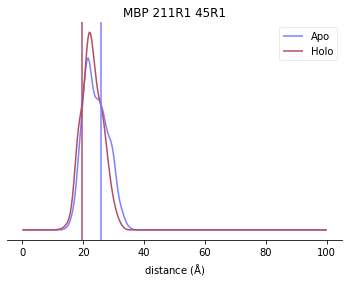

In [57]:
arg = 6055            
site1, site2 = all_pairs[arg]
omp_SL1 = omp_spin_labels[site1]
omp_SL2 = omp_spin_labels[site2]

anf_SL1 = anf_spin_labels[site1]
anf_SL2 = anf_spin_labels[site2]

omp_cbd = np.linalg.norm(omp_SL1.coords[0, omp_SL1.atom_names=='CB'] - omp_SL2.coords[0, omp_SL2.atom_names=='CB'])
anf_cbd = np.linalg.norm(anf_SL1.coords[0, anf_SL1.atom_names=='CB'] - anf_SL2.coords[0, anf_SL2.atom_names=='CB'])


fig, ax = plt.subplots()
ax.set_title(f'MBP {site1[0]}R1 {site2[0]}R1')

ax.plot(r, Ps_omp[arg], label='Apo')
ax.plot(r, Ps_anf[arg], label='Holo')

ax.axvline(omp_cbd, color='C0')
ax.axvline(anf_cbd, color='C1')

ax.set_yticks([])
ax.set_xlabel(r'distance ($\rm\AA$)')
ax.legend()

for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

fig.savefig(f'MBP {site1[0]}R1 {site2[0]}R1 Pr.png', bbox_inches='tight', dpi=1000)
xl.save('omp_S2.pdb', omp_SL1, omp_SL2, omp)
xl.save('anf_S2.pdb', anf_SL1, anf_SL2, anf)


In [43]:
xl.save(omp_SL1, omp_SL2, omp)
xl.save(anf_SL1, anf_SL2, anf)